# Class Activation Map(CAM)
### 목표
- CAM을 얻기 위한 기본모델의 구성
- 분류근거를 설명할 수 있는 CAM획득
- 인식결과의 시각화 및 성능 분석

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import os
import cv2
from PIL import Image

### 데이터셋 준비

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

stanford_dogs 데이터셋은 아래와 같이 구성되어 있습니다.
- image : 이미지
- image/filename : 파일명
- label : 클래스 레이블
- bbox : 바운딩박스(minmax방식)

In [4]:
# 이미지 normalization 및 사이즈 조절
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 모델 불러오기

In [5]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [6]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### cam

In [7]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [8]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

100


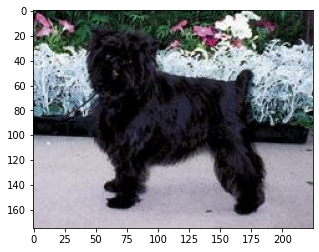

In [9]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### cam이미지 생성

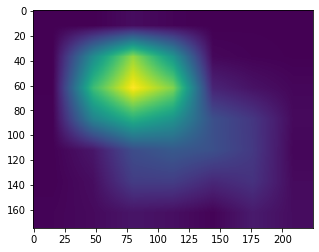

In [10]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

### visualize_cam_on_image

In [11]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

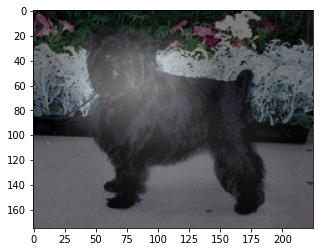

In [12]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### grad_cam

In [13]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

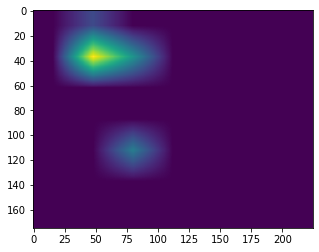

In [14]:
# grad_cam 이미지 생성
grad_cam_image1 = generate_grad_cam(cam_model, 'conv5_block1_3_conv', item)
# grad_cam 이미지 시각화
plt.imshow(grad_cam_image1)

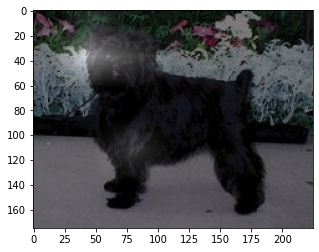

In [15]:
cam_image_3channel1 = np.stack([grad_cam_image1*255]*3, axis=-1).astype(np.uint8)

blended_image1 = visualize_cam_on_image(cam_image_3channel1, origin_image)
plt.imshow(blended_image1)

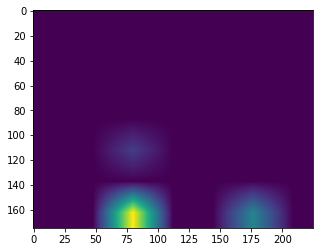

In [16]:
# grad_cam 이미지 생성
grad_cam_image2 = generate_grad_cam(cam_model, 'conv5_block1_2_conv', item)
# grad_cam 이미지 시각화
plt.imshow(grad_cam_image2)

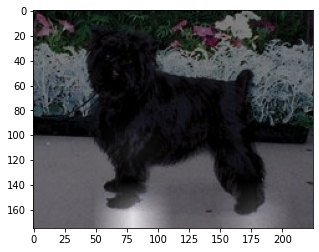

In [17]:
cam_image_3channel2 = np.stack([grad_cam_image2*255]*3, axis=-1).astype(np.uint8)

blended_image2 = visualize_cam_on_image(cam_image_3channel2, origin_image)
plt.imshow(blended_image2)

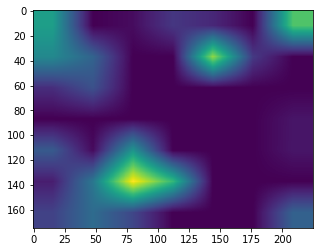

In [18]:
# grad_cam 이미지 생성
grad_cam_image3 = generate_grad_cam(cam_model, 'conv5_block1_1_conv', item)
# grad_cam 이미지 시각화
plt.imshow(grad_cam_image3)

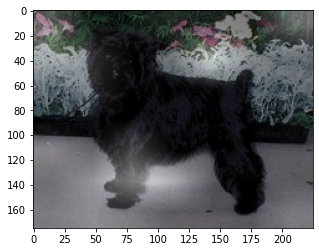

In [19]:
cam_image_3channel3 = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image3 = visualize_cam_on_image(cam_image_3channel3, origin_image)
plt.imshow(blended_image3)

### IoU

In [20]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [21]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [22]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

### cam의 iou

In [23]:
# cam 이미지의 bounding box
rect = get_bbox(cam_image)
rect

array([[ 18,  13],
       [202,  13],
       [202, 174],
       [ 18, 174]])

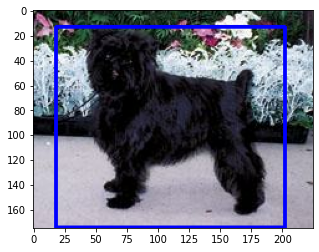

In [24]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [25]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.07428571428571429, 0.08, 0.9942857142857143, 0.8977777777777778]

In [26]:
# ground truth bbox
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [27]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7799082032505189

### grad_cam의 iou
1. 첫번째 grad_cam

In [28]:
# grad_cam 이미지의 bounding box
rect1 = get_bbox(grad_cam_image1)
rect1

array([[ 52,  91],
       [108,  91],
       [108, 133],
       [ 52, 133]])

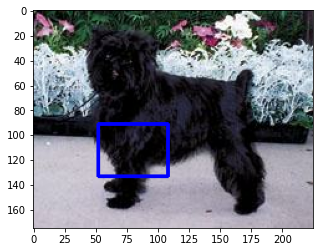

In [29]:
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image1, [rect1], 0, (0,0,255), 2)
plt.imshow(image1)
plt.show()

In [30]:
pred_bbox1 = rect_to_minmax(rect1, item['image'])
pred_bbox1

[0.52, 0.2311111111111111, 0.76, 0.48]

In [31]:
# ground truth bbox
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [32]:
get_iou(pred_bbox1, item['objects']['bbox'][0])

0.10180055131521625

2. 두번째 grad_cam

In [33]:
# grad_cam 이미지의 bounding box
rect2 = get_bbox(grad_cam_image2)
rect2

array([[148, 140],
       [204, 140],
       [204, 174],
       [148, 174]])

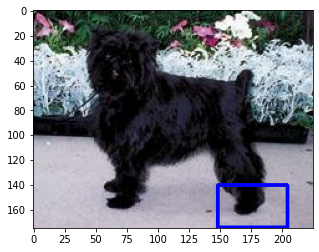

In [34]:
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)
plt.imshow(image2)
plt.show()

In [35]:
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox2

[0.8, 0.6577777777777778, 0.9942857142857143, 0.9066666666666666]

In [36]:
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.044524263836079235

3. 세번째 grad_cam

In [37]:
# grad_cam 이미지의 bounding box
rect3 = get_bbox(grad_cam_image3)
rect3

array([[182, 142],
       [224, 142],
       [224, 174],
       [182, 174]])

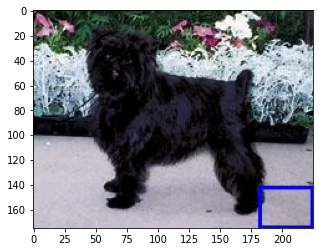

In [38]:
image3 = copy.deepcopy(item['image'])
image3 = cv2.drawContours(image3, [rect3], 0, (0,0,255), 2)
plt.imshow(image3)
plt.show()

In [39]:
pred_bbox3 = rect_to_minmax(rect3, item['image'])
pred_bbox3

[0.8114285714285714,
 0.8088888888888889,
 0.9942857142857143,
 0.9955555555555555]

In [40]:
get_iou(pred_bbox3, item['objects']['bbox'][0])

0.006919269837007198

### pre-trained 모델을 사용한 결과 회고
- cam에서는 최종출력에 가장 가까운 레이어의 피처맵을 봐서 iou가 높았지만 grad_cam에서는 은닉층 중간의 피처맵의 iou를 계산해서 낮은 iou가 출력되었다. 또 블록마다 다른 부분을 지켜보고 있었기 때문에 iou의 편차도 많이 높았다.
- cam에서의 바운딩박스는 육안으로 보기에도 비교적 ground truth인 바운딩박스와 비슷한 범위를 나타내고 있었다.
- grad_cam에서는 같은 레이어이더라도 다른 블록에 있을 경우 확연히 다른 부분을 보고 있다는 점을 확인할 수 있었다.
- 바운딩 박스를 치는 부분에서 grad_cam을 통해 확인된 활성화된 부분과 바운딩박스의 위치가 크게 차이나는 것으로 보이는 경우가 자주 발생했다.
    - cv2.contour의 문제라고 생각해 다른 그루분이 좀 더 포괄적으로 바운딩박스를 칠 수 있는 최대치의 contour를 찾는 방법을 제안해 주셨다.
    ```python
        # 가장 큰 면적의 컨투어 선택
        largest_contour = max(contours, key=cv2.contourArea)

        # 최소 면적 바운딩 박스 계산
        rotated_rect = cv2.minAreaRect(largest_contour)
        rect = cv2.boxPoints(rotated_rect)
        rect = np.int0(rect)
    ```

### 직접 모델 구성하고 학습시켜서 cam과 grad_cam출력해보기
- 이전에 사용했던 것과 같은 구조의 resnet50을 사용
- 총 20에폭의 학습을 진행 후 콜백을 통해 가장 나은 결과를 저장 후 사용

In [41]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg', 
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
new_model = keras.Model(inputs=base_model.input, outputs=preds)

new_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

데이터셋 정규화

In [42]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

체크포인트 콜백 사용

In [43]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='new_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

모델 학습
- 학습률 0.01 20에폭으로 훈련한 결과 약 5에폭에서 과대적합이 이루어저 학습률 0.005, 15에폭으로 조정하여 학습

In [44]:
new_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
    metrics=['accuracy'],
)

'''history_new_model = new_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback]
)'''

"history_new_model = new_model.fit(\n    ds_train_norm,\n    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),\n    validation_steps=int(ds_info.splits['test'].num_examples/16),\n    epochs=15,\n    validation_data=ds_val_norm,\n    verbose=1,\n    use_multiprocessing=True,\n    callbacks=[checkpoint_callback]\n)"

In [45]:
new_model = tf.keras.models.load_model('new_model.h5')

cam과 grad_cam이미지 생성

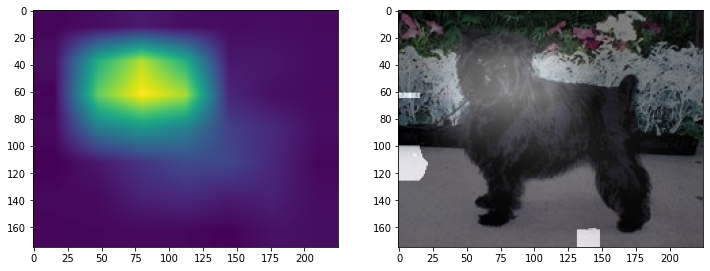

In [46]:
cam_image = generate_cam(new_model, item)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cam_image)

cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.subplot(1, 2, 2)
plt.imshow(blended_image)

plt.show()

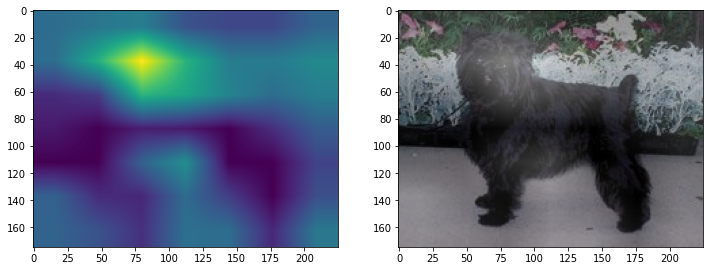

In [47]:
# grad_cam 이미지 생성
grad_cam_image1 = generate_grad_cam(new_model, 'conv5_block1_3_conv', item)
# grad_cam 이미지 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(grad_cam_image1)

cam_image_3channel1 = np.stack([grad_cam_image1*255]*3, axis=-1).astype(np.uint8)

blended_image1 = visualize_cam_on_image(cam_image_3channel1, origin_image)
plt.subplot(1, 2, 2)
plt.imshow(blended_image1)

plt.show()

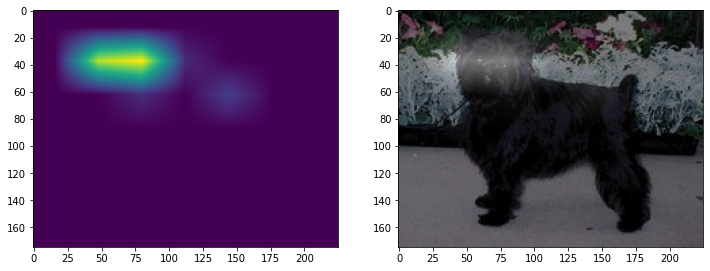

In [48]:
# grad_cam 이미지 생성
grad_cam_image2 = generate_grad_cam(new_model, 'conv5_block1_2_conv', item)
# grad_cam 이미지 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(grad_cam_image2)

cam_image_3channel2 = np.stack([grad_cam_image2*255]*3, axis=-1).astype(np.uint8)

blended_image2 = visualize_cam_on_image(cam_image_3channel2, origin_image)
plt.subplot(1, 2, 2)
plt.imshow(blended_image2)

plt.show()

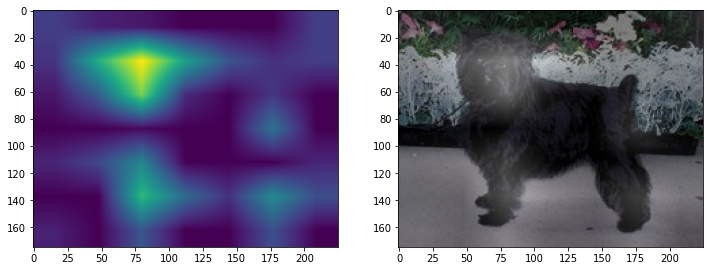

In [49]:
# grad_cam 이미지 생성
grad_cam_image3 = generate_grad_cam(new_model, 'conv5_block1_1_conv', item)
# grad_cam 이미지 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(grad_cam_image3)

cam_image_3channel3 = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image3 = visualize_cam_on_image(cam_image_3channel3, origin_image)
plt.subplot(1, 2, 2)
plt.imshow(blended_image3)

plt.show()

cam 및 grad_cam의 iou

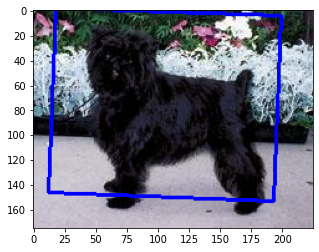

In [50]:
# cam 이미지의 bounding box
rect = get_bbox(cam_image)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [51]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6824068399014978

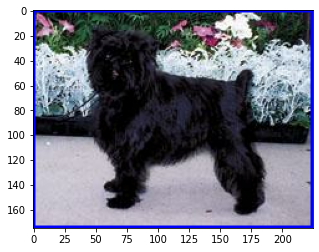

In [52]:
# grad_cam 이미지의 bounding box
rect1 = get_bbox(grad_cam_image1)
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image1, [rect1], 0, (0,0,255), 2)
plt.imshow(image1)
plt.show()

In [53]:
pred_bbox1 = rect_to_minmax(rect1, item['image'])
get_iou(pred_bbox1, item['objects']['bbox'][0])

0.5927750567809261

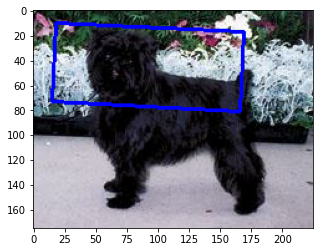

In [54]:
# grad_cam 이미지의 bounding box
rect2 = get_bbox(grad_cam_image2)
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)
plt.imshow(image2)
plt.show()

In [55]:
pred_bbox2 = rect_to_minmax(rect2, item['image'])
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.35103595290247996

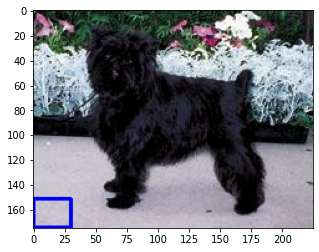

In [56]:
# grad_cam 이미지의 bounding box
rect3 = get_bbox(grad_cam_image3)
image3 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image3, [rect3], 0, (0,0,255), 2)
plt.imshow(image3)
plt.show()

In [57]:
pred_bbox3 = rect_to_minmax(rect3, item['image'])
get_iou(pred_bbox3, item['objects']['bbox'][0])

0.0

### 직접 훈련한 모델의 결과 회고
- 앞서 언급했던 바운딩박스의 문제는 어김없이 발생했고 실제 grad_cam을 통해 확인된 활성화 위치와 바운딩박스의 위치는 크게 상이한 경우가 있었다.
- 또 cam에서 원본이미지와 합성한 결과에 뚜렷한 밝기의 경계선이 나타나는 현상이 발생했다.
    - 특정 값에서 언더/오버플로우가 발생한 것인지 확인할 필요가 있다.
    - ReLU와 같은 특정구간에서 미분 불가능한 활성화함수의 영향인지 확인할 필요가 있다.
- 대개 최종 출력에 가장 가까운 cam에서 가장 높은 iou를 나타내고 있고 일부 grad_cam에서 가끔 높은 iou를 보이고 있다.

### 추가실험 필요한 부분
- 이미지에 노이즈를 섞어 cam과 grad_cam을 살펴보기